# Employee Turnover Prediction (Logistic Regression)

This notebook builds a **Logistic Regression** model to predict whether an employee will leave the company (**Employee_Turnover** = 1) based on HR features.

### What you will see in this notebook
1. Load & explore dataset
2. Data preprocessing (handling categorical + scaling numeric)
3. Baseline Logistic Regression
4. Regularized Logistic Regression:
   - **L1 (Lasso)**
   - **L2 (Ridge)**
5. Hyperparameter tuning using **GridSearchCV**
6. Evaluation: Accuracy, Precision, Recall, F1, Confusion Matrix, ROC-AUC + ROC Curve
7. Feature importance (model coefficients)
8. Final conclusion


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report,
    ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)

# Make plots a bit larger
plt.rcParams['figure.figsize'] = (7, 5)


## 1. Load Dataset

Make sure your dataset file is in the same folder as this notebook.

- File expected: `employee_turnover.csv`
- Target column: `Employee_Turnover`


In [6]:
# Load dataset
# NOTE: change this path if your file is stored elsewhere
DATA_PATH = 'employee_turnover.csv'

df = pd.read_csv(DATA_PATH)
df.head()


,Job_Satisfaction,Performance_Rating,Years_At_Company,Work_Life_Balance,Distance_From_Home,Monthly_Income,Education_Level,Age,Num_Companies_Worked,Employee_Role,Annual_Bonus,Training_Hours,Department,Annual_Bonus_Squared,Annual_Bonus_Training_Hours_Interaction,Employee_Turnover
0,0.562326,0.141129,0.123989,0.347583,0.330353,0.328853,0.600933,0.315990,0.768736,0.090671,0.324786,0.669193,0.602932,0.105486,0.217344,0
1,0.017041,0.559047,0.511203,0.793908,0.423550,0.553450,0.742009,0.897146,0.380035,0.601633,0.694611,0.043271,0.800761,0.482484,0.030056,0
2,0.774699,0.604371,0.798174,0.260500,0.804034,0.131800,0.775178,0.830947,0.218726,0.972936,0.153476,0.701336,0.705275,0.023555,0.107638,1
3,0.628174,0.385249,0.230104,0.516809,0.272248,0.589249,0.482409,0.090507,0.402746,0.132842,0.305973,0.549688,0.600531,0.093620,0.168190,0
4,0.799183,0.199967,0.839029,0.247927,0.341934,0.076818,0.055356,0.680860,0.923341,0.493017,0.844094,0.793751,0.664679,0.712494,0.670000,0


In [7]:
# Basic dataset overview
print('Shape:', df.shape)
df.info()


Shape: (1350, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Job_Satisfaction                         1350 non-null   float64
 1   Performance_Rating                       1350 non-null   float64
 2   Years_At_Company                         1350 non-null   float64
 3   Work_Life_Balance                        1350 non-null   float64
 4   Distance_From_Home                       1350 non-null   float64
 5   Monthly_Income                           1350 non-null   float64
 6   Education_Level                          1350 non-null   float64
 7   Age                                      1350 non-null   float64
 8   Num_Companies_Worked                     1350 non-null   float64
 9   Employee_Role                            1350 non-null   float64
 10  Annual_Bonus                  

In [8]:
# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]


Series([], dtype: int64)

## 2. Define Features (X) and Target (y)


In [13]:
X = df.drop('Employee_Turnover', axis=1)
y = df['Employee_Turnover']

print("Target distribution:")
print(y.value_counts())

print("\nTarget distribution (%):")
print((y.value_counts(normalize=True) * 100).round(2))



Target distribution:
Employee_Turnover
0    678
1    672
Name: count, dtype: int64

Target distribution (%):
Employee_Turnover
0    50.22
1    49.78
Name: proportion, dtype: float64


## 3. Train/Test Split

We use **stratify=y** to keep class distribution stable in train and test.


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape :', X_test.shape)


Train shape: (1080, 15)
Test shape : (270, 15)


## 4. Preprocessing Pipeline

Logistic Regression performs better when:
- Numeric columns are **scaled**
- Categorical columns are **one-hot encoded**

This notebook automatically detects numeric & categorical columns.


In [15]:
# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

print('Numeric columns:', list(num_cols))
print('Categorical columns:', list(cat_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)


Numeric columns: ['Job_Satisfaction', 'Performance_Rating', 'Years_At_Company', 'Work_Life_Balance', 'Distance_From_Home', 'Monthly_Income', 'Education_Level', 'Age', 'Num_Companies_Worked', 'Employee_Role', 'Annual_Bonus', 'Training_Hours', 'Department', 'Annual_Bonus_Squared', 'Annual_Bonus_Training_Hours_Interaction']
Categorical columns: []


## 5. Baseline Logistic Regression


In [16]:
baseline_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

baseline_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Job_Satisfaction', 'Performance_Rating', 'Years_At_Company',
       'Work_Life_Balance', 'Distance_From_Home', 'Monthly_Income',
       'Education_Level', 'Age', 'Num_Companies_Worked', 'Employee_Role',
       'Annual_Bonus', 'Training_Hours', 'Department', 'Annual_Bonus_Squared',
       'Annual_Bonus_Training_Hours_Interaction'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

## 6. Evaluation Function

This function prints:
- Accuracy
- ROC-AUC
- Classification Report
- Confusion Matrix
- ROC Curve


In [18]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("\n" + "=" * 40)
    print(name)
    print("=" * 40)
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("ROC-AUC :", round(roc_auc_score(y_test, y_prob), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{name} - ROC Curve")
    plt.show()



Baseline Logistic Regression
Accuracy: 0.8815
ROC-AUC : 0.9583

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       136
           1       0.89      0.87      0.88       134

    accuracy                           0.88       270
   macro avg       0.88      0.88      0.88       270
weighted avg       0.88      0.88      0.88       270



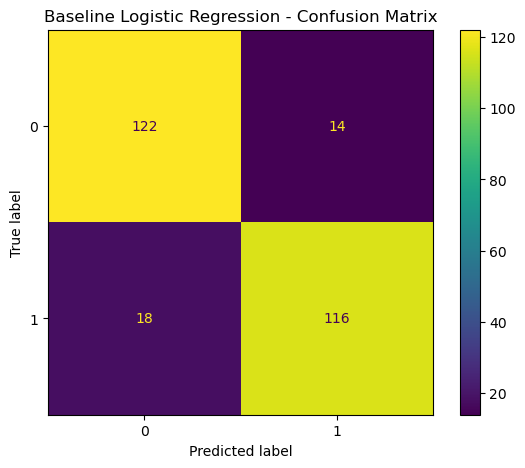

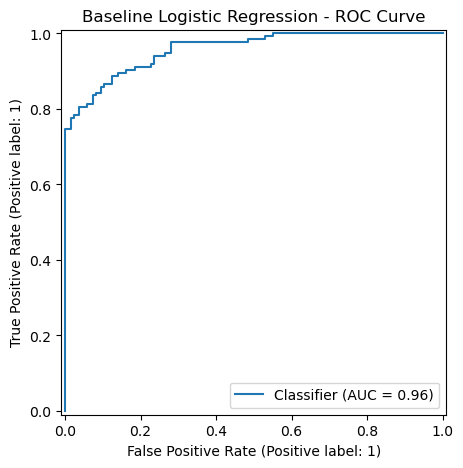

In [19]:
evaluate_model('Baseline Logistic Regression', baseline_model)


## 7. Regularization (L1 and L2) + Hyperparameter Tuning

We use **GridSearchCV** to find the best `C` value.

- L1 uses solver `liblinear`
- L2 can use default solver

Scoring metric: **ROC-AUC** (good for imbalanced classification)


In [21]:
# L1 (Lasso) Logistic Regression
l1_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])

l1_params = {'model__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}

l1_grid = GridSearchCV(
    l1_pipeline,
    param_grid=l1_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

l1_grid.fit(X_train, y_train)

print("Best L1 params:", l1_grid.best_params_)
print("Best L1 CV ROC-AUC:", round(l1_grid.best_score_, 4))


# L2 (Ridge) Logistic Regression
l2_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(penalty='l2', max_iter=1000))
])

l2_params = {'model__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}

l2_grid = GridSearchCV(
    l2_pipeline,
    param_grid=l2_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

l2_grid.fit(X_train, y_train)

print("\nBest L2 params:", l2_grid.best_params_)
print("Best L2 CV ROC-AUC:", round(l2_grid.best_score_, 4))


Best L1 params: {'model__C': 0.05}
Best L1 CV ROC-AUC: 0.9434

Best L2 params: {'model__C': 0.05}
Best L2 CV ROC-AUC: 0.9434



L1 Regularized Logistic Regression
Accuracy: 0.8815
ROC-AUC : 0.9605

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       136
           1       0.89      0.87      0.88       134

    accuracy                           0.88       270
   macro avg       0.88      0.88      0.88       270
weighted avg       0.88      0.88      0.88       270



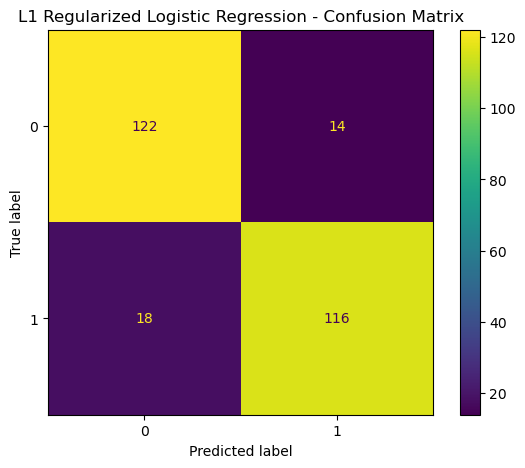

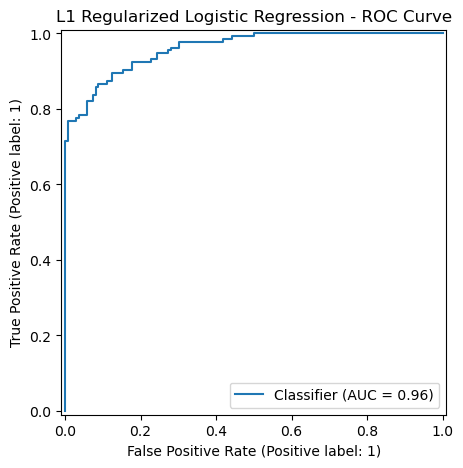


L2 Regularized Logistic Regression
Accuracy: 0.8852
ROC-AUC : 0.9585

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89       136
           1       0.90      0.87      0.88       134

    accuracy                           0.89       270
   macro avg       0.89      0.89      0.89       270
weighted avg       0.89      0.89      0.89       270



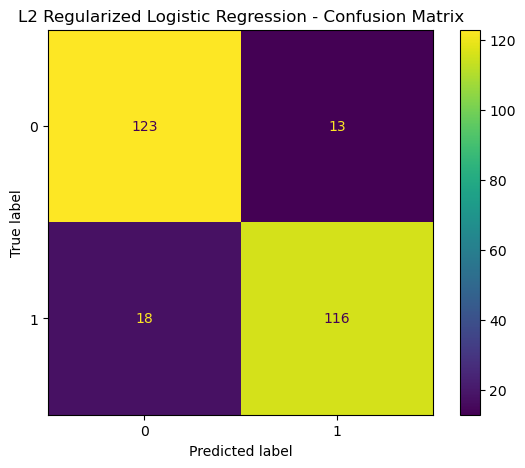

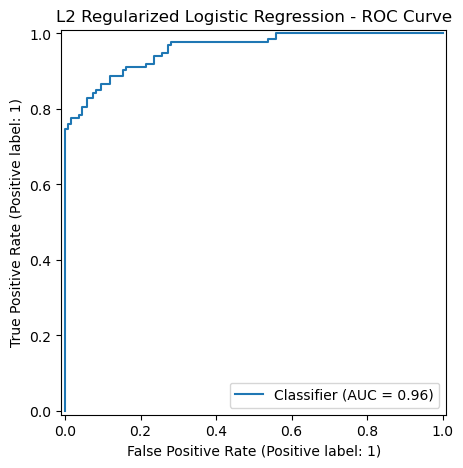

In [22]:
best_l1 = l1_grid.best_estimator_
best_l2 = l2_grid.best_estimator_

evaluate_model('L1 Regularized Logistic Regression', best_l1)
evaluate_model('L2 Regularized Logistic Regression', best_l2)


## 8. Feature Importance (Coefficients)

For Logistic Regression, coefficient values show influence:
- Positive coefficient → increases probability of Turnover
- Negative coefficient → decreases probability of Turnover


In [24]:
def show_top_coefficients(best_model, top_n=10):
    model = best_model.named_steps['model']
    preprocess = best_model.named_steps['preprocess']

    feature_names = preprocess.get_feature_names_out()
    coefs = model.coef_[0]

    coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
    coef_df = coef_df.sort_values('coef', ascending=False)

    print("\nTop features increasing Turnover:")
    display(coef_df.head(top_n))

    print("\nTop features decreasing Turnover:")
    display(coef_df.tail(top_n))

show_top_coefficients(best_l2)




Top features increasing Turnover:


,feature,coef
0,num__Job_Satisfaction,1.116002
1,num__Performance_Rating,1.091597
3,num__Work_Life_Balance,1.053724
4,num__Distance_From_Home,1.028648
2,num__Years_At_Company,0.940879
13,num__Annual_Bonus_Squared,0.109597
11,num__Training_Hours,0.097588
9,num__Employee_Role,0.087047
8,num__Num_Companies_Worked,-0.017518
7,num__Age,-0.022704



Top features decreasing Turnover:


,feature,coef
13,num__Annual_Bonus_Squared,0.109597
11,num__Training_Hours,0.097588
9,num__Employee_Role,0.087047
8,num__Num_Companies_Worked,-0.017518
7,num__Age,-0.022704
10,num__Annual_Bonus,-0.042301
5,num__Monthly_Income,-0.057476
12,num__Department,-0.088475
14,num__Annual_Bonus_Training_Hours_Interaction,-0.091155
6,num__Education_Level,-0.187133


## 9. Final Conclusion

Write your final conclusion after checking results.

Example structure:
- **Best model:** (Baseline / L1 / L2)
- **Reason:** best ROC-AUC / best recall for turnover / stable performance
- **Business interpretation:** what the model tells about turnover drivers
